In [1]:
import pandas as pd
import pdb
import numpy as np
import itertools
from utils import *
from snakemake.io import expand
import yaml
import cerberus
import pyranges as pr
import upsetplot
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from matplotlib_venn import venn3

In [2]:
config_file = 'workflow/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [29]:
def do_rank_thing(novs):
    ranks = [i for i in range(len(novs))]
    nov_rank = dict([(nov, rank) for nov, rank in zip(novs, ranks)])
    rank_nov = dict()
    for key, item in nov_rank.items():
        rank_nov[item] = key
    return nov_rank, rank_nov
    
def get_biotype_ranks():
    ranks = ['protein_coding', 'lncRNA', 'pseudogene', 'miRNA', 'other']
    rank1, rank2 = do_rank_thing(ranks)
    return rank1, rank2
    
def get_nov_ranks():
    """
    Get rank for each novelty category

    Returns:
        nov_rank (dict): Dictionary of novelty category: int rank
        rank_nov (dict): Dictionary of int rank: novelty category
    """
    novs = ['Known', 'NIC', 'ISM', 'NNC', 'Unspliced']
    nov_rank, rank_nov = do_rank_thing(novs)
    # ranks = [i for i in range(len(novs))]
    # nov_rank = dict([(nov, rank) for nov, rank in zip(novs, ranks)])
    # rank_nov = dict()
    # for key, item in nov_rank.items():
    #     rank_nov[item] = key

    return nov_rank, rank_nov

def make_unique_region_id(df):
    """
    Make a unique region ID for BED regions that don't 
    alread have unique identifiers
    """
    df['region_id'] = df['group_name']+'_'+\
                      df['Chromosome'].astype(str)+'_'+\
                      df['Start'].astype(str)+'_'+\
                      df['End'].astype(str)#+'_'+\
                      #df['Strand'].astype(str)
    df = df.drop_duplicates()
    return df

def read_beds(files, name, keep_cols=True):
    df = pd.DataFrame()
    for f in files:
        temp = pd.read_csv(f, sep='\t')
        df = pd.concat([df, temp], axis=0)

        # retain just the identifying characteristics 
        # df = df[['Chromosome', 'Start', 'End', 'Strand']]
        if not keep_cols:
            df = df[['Chromosome', 'Start', 'End']]
    df['group_name']  = name
    df = make_unique_region_id(df)
    return df
    
def three_way_intersect(fa,
                        fa_group,
                        fb,
                        fb_group,
                        fc,
                        fc_group):
    
    def intersect_thing(a, a_name,
                        b, b_name,
                        c, c_name):
        
        # code largely stolen from here: https://github.com/asntech/intervene/blob/master/intervene/modules/upset/upset.py
        counts = {}
        intersect_beds = {}
        input_files = [a, b, c]
        input_file_names = [a_name, b_name, c_name]
        
        N=len(input_files)
        truth_table = [x for x in itertools.product("01", repeat=N)][1:]
        
        for t in truth_table:
            ones = [input_files[i] for i in range(N) if t[i] =='1']
            zeros = [input_files[i] for i in range(N) if t[i] =='0']
            
            # report those entries in set A which do ovelap with other sets
            x = ones[0]
            if len(ones) > 1:
                for bed in ones[1:]:
                    x = x.overlap(bed,
                         how='first')
                    
            # report those entries in set A which doesn't ovelap with other sets
            if len(zeros) > 0:
                for bed in zeros[0:]:
                    x = x.overlap(bed,
                         how='first',
                         invert=True)

            X = len(x.df.index)

            # just check 
            temp = x.df
            n1 = len(temp.index)
            n2 = len(temp.region_id.unique())
            assert n1 == n2

            key = ','.join([input_file_names[i] for i in range(len(t)) if t[i]=='1'])
            counts[''.join(t)] = X
            intersect_beds[key] = x.df
            
        return counts, intersect_beds

    
    # read in beds
    fa_df = read_beds(fa, 
                      fa_group,
                      keep_cols=False)
    fb_df = read_beds(fb, 
                      fb_group,
                      keep_cols=False)
    fc_df = read_beds(fc,
                      fc_group,
                      keep_cols=False)
    
    # perform intersections: 
    fa_pr = pr.PyRanges(fa_df)
    fb_pr = pr.PyRanges(fb_df)
    fc_pr = pr.PyRanges(fc_df)
    
    counts, intersect_beds = intersect_thing(fa_pr, fa_group,
                                              fb_pr, fb_group,
                                              fc_pr, fc_group)
    
    venn3(counts, set_labels=[fa_group, fb_group, fc_group])
    
    return counts, intersect_beds

def get_biotype_map():
    """
    Get a dictionary mapping each gene type to a more general biotype
    """
    map = {'protein_coding': ['protein_coding'],
           'lncRNA': ['lincRNA',
                      'lncRNA',
                      'processed_transcript',
                      'sense_intronic',
                      '3prime_overlapping_ncRNA',
                      'bidirectional_promoter_lncRNA',
                      'sense_overlapping',
                      'non_coding',
                      'macro_lncRNA',
                      'antisense'],
           'pseudogene': ['unprocessed_pseudogene',
                          'translated_unprocessed_pseudogene',
                          'transcribed_unprocessed_pseudogene',
                          'processed_pseudogene',
                          'transcribed_processed_pseudogene',
                          'transcribed_unitary_pseudogene',
                          'unitary_pseudogene',
                          'polymorphic_pseudogene',
                          'pseudogene',
                          'translated_processed_pseudogene'],
           'miRNA': ['miRNA'],
           'other': ['snRNA', 'vault_RNA',
                     'misc_RNA', 'TEC',
                     'snoRNA', 'scaRNA',
                     'rRNA_pseudogene', 'rRNA',
                     'IG_V_pseudogene',
                     'scRNA', 'IG_V_gene',
                     'IG_C_gene', 'IG_J_gene',
                     'sRNA', 'ribozyme',
                     'vaultRNA', 'TR_C_gene',
                     'TR_J_gene', 'TR_V_gene',
                     'TR_V_pseudogene', 'TR_D_gene',
                     'IG_C_pseudogene', 'IG_D_gene',
                     'IG_pseudogene', 'Mt_tRNA',
                     'Mt_rRNA', 'TR_J_pseudogene',
                     'IG_J_pseudogene']}
    return map

## 231024 PLS cCRE characterization

In [30]:
species = 'human'

ca_h5 = expand(config['lr']['ca'], species=species)[0]
gtf_file = expand(config['ref']['gtf'], species=species)[0]

files_a_name = 'cCRE'
files_a = expand(config['ccre']['bed_format'],
                       species='human',
                  ccre_type=['pls'])

files_b_name = 'ProCap'
files_b = expand(config['procap']['bed_format'],
                     pc_biosamp='k562',
                     pc_rep=[str(i) for i in range(1,7)],
                     pc_output=['bidirectional_peaks', 'unidirectional_peaks'],
                     species=species)
files_c_name = 'LR'
files_c = expand(config['lr']['bed_format'],
                     lr_biosamp='k562',
                     lr_rep=['1', '2', '3'],
                     species=species)

                       # ccre_type=['pls', 'dels', 'pels'])


In [31]:
gtf_df = pr.read_gtf(gtf_file, duplicate_attr=True)
gtf_df = gtf_df.features.tss()

In [32]:
gtf_df = gtf_df.df
map = get_biotype_map()

# pivot map
biotype_map = {}
for key, biotypes in map.items():
    for biotype in biotypes:
        biotype_map[biotype] = key
# then add map to df
gtf_df['biotype_category'] = gtf_df.gene_type.map(biotype_map)
gtf_df['basic'] = gtf_df.tag.str.contains('basic')
print(gtf_df.basic.unique())

gtf_df.basic.fillna(False, inplace=True)
# gtf_df.loc[gtf_df.basic=='-1', 'basic'] = False
print(gtf_df.basic.unique())

gtf_df = pr.PyRanges(gtf_df)       

[True False nan]
[ True False]


In [33]:
gtf_df = gtf_df.df
gtf_df = gtf_df[['Chromosome', 'Start', 'End', 'Strand', 'biotype_category', 'gene_id', 'basic']]
gtf_df = pr.PyRanges(gtf_df)

In [46]:
temp = pr.read_bed(files_a[0])
len(temp.df.index)

47532

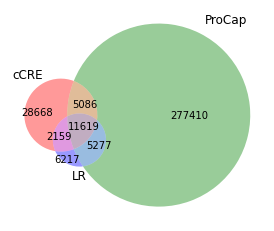

In [34]:
counts, int_beds = three_way_intersect(files_a,
                        files_a_name,
                        files_b,
                        files_b_name,
                        files_c,
                        files_c_name)

In [35]:
print(counts)
print(files_a_name)
print(files_b_name)
print(files_c_name)

{'001': 6217, '010': 277410, '011': 5277, '100': 28668, '101': 2159, '110': 5086, '111': 11619}
cCRE
ProCap
LR


In [39]:
int_beds.keys()

dict_keys(['LR', 'ProCap', 'ProCap,LR', 'cCRE', 'cCRE,LR', 'cCRE,ProCap', 'cCRE,ProCap,LR'])

In [47]:
((47532-(28668)/47532)*100

39.68694774046958

cCRE
47532
28668


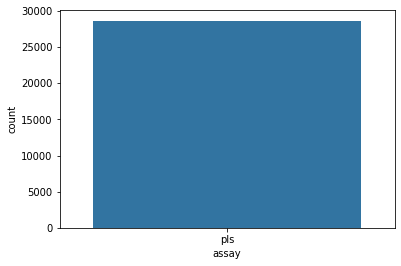

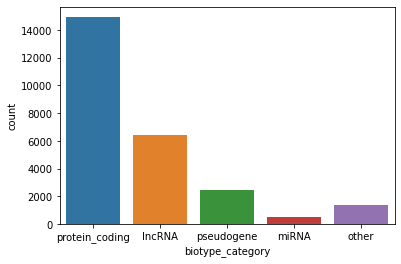

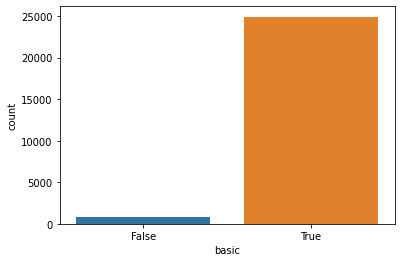


cCRE,LR
47532
2159


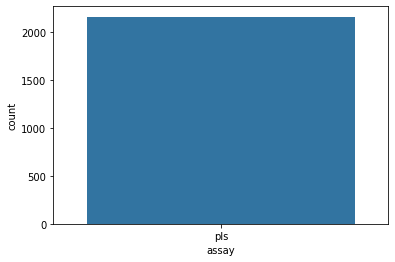

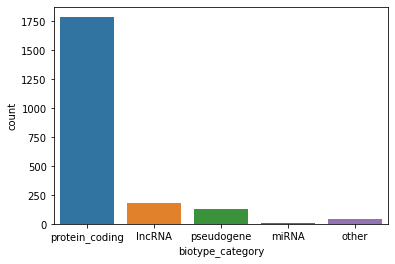

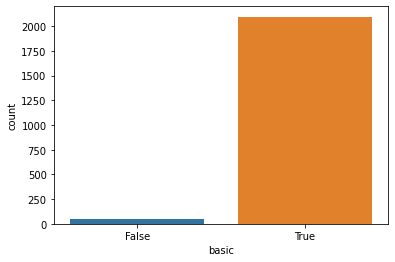


cCRE,ProCap
47532
5086


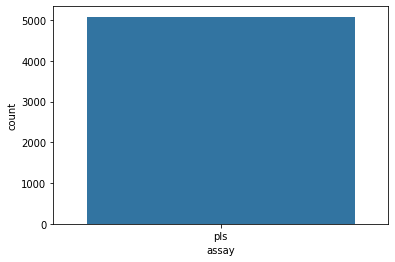

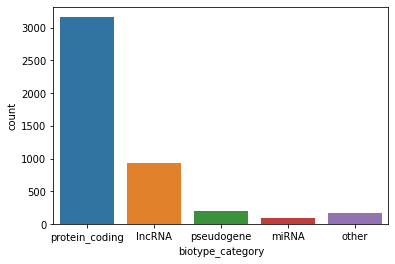

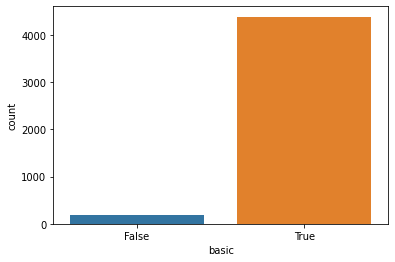


cCRE,ProCap,LR
47532
11619


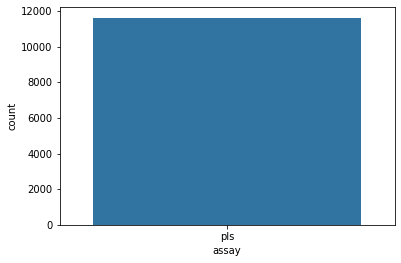

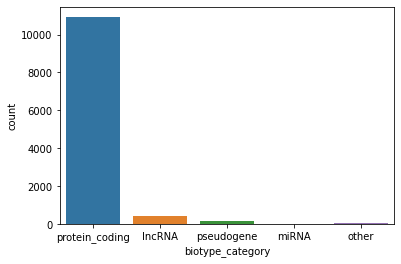

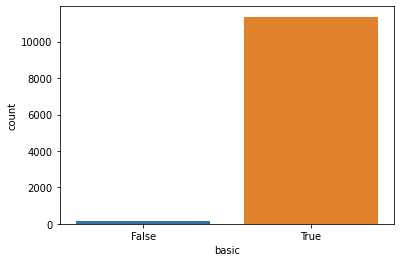

<Figure size 432x288 with 0 Axes>

In [36]:
for key, item in int_beds.items():
    if files_a_name not in key:
        continue
    print(key)
    df = int_beds[key]
    ccre_df = read_beds(files_a, files_a_name)    
    
      # this is wrong, the things from df are not supported
#     # get regions from original thing that were present in this
#     # intersection file
#     ccre_df['supported'] = False
#     ccre_df.loc[ccre_df.region_id.isin(df.region_id.tolist()), 'supported'] = True
#     temp = ccre_df[['assay', 'supported', 'region_id']].copy(deep=True)
#     temp = temp[['assay', 'region_id']].groupby('assay').count().reset_index().rename({'region_id':'n_total_ccres'}, axis=1)
#     temp2 = ccre_df[['assay', 'supported', 'region_id']].copy(deep=True)
#     temp2 = temp2.groupby(['assay', 'supported']).count().reset_index().rename({'region_id':'n_ccres'}, axis=1)
#     temp2 = temp2.merge(temp, on='assay', how='left')
#     temp2['perc'] = (temp2.n_ccres/temp2.n_total_ccres)*100
#     temp2 = temp2.loc[temp2.supported==True]
#     sns.catplot(temp2, x='assay', y='perc', kind='bar')    
#     import pdb; pdb.set_trace()
#     plt.show()
#     plt.clf()
    
    # get regions from original thing that were present in this
    # intersection file
    print(len(ccre_df.index))
    ccre_df = ccre_df.loc[ccre_df.region_id.isin(df.region_id.tolist())]
    print(len(ccre_df.index))
    sns.countplot(ccre_df, x='assay')    
    plt.show()
    plt.clf()
    
    # for plss, which types of genes are they from?
    pls_df = ccre_df.loc[ccre_df.assay=='pls']
    pls_df = pr.PyRanges(pls_df)
    pls_df = pls_df.join(gtf_df, 
                       how='left',
                       slack=200,
                       strandedness=None)
    pls_df = pls_df.df
    
    # biotype
    rank1, rank2 = get_biotype_ranks()
    pls_df['biotype_rank'] = pls_df.biotype_category.map(rank1)
    temp = pls_df.loc[pls_df.biotype_rank.notnull()]
    temp = temp.sort_values(by='biotype_rank', ascending=True)
    # pls_df.loc[pls_df.region_id=='cCRE_chr4_82402223_82402572']
    temp = temp.drop_duplicates(subset='region_id', keep='first')
    # pls_df.loc[pls_df.region_id=='cCRE_chr4_82402223_82402572']
    sns.countplot(temp, x='biotype_category')
    
    plt.show()
    plt.clf()
    
    # basic or not
    temp = pls_df.loc[pls_df.basic.notnull()]
    temp = temp.loc[temp.basic!='-1']
    temp = temp.sort_values(by='basic', ascending=False)
    temp = temp.drop_duplicates(subset='region_id', keep='first')
    sns.countplot(temp, x='basic')
    
    plt.show()
    plt.clf()
    print()


## PLS + pELS + dELS

In [48]:
species = 'human'

ca_h5 = expand(config['lr']['ca'], species=species)[0]
gtf_file = expand(config['ref']['gtf'], species=species)[0]

files_a_name = 'cCRE'
files_a = expand(config['ccre']['bed_format'],
                       species='human',
                  ccre_type=['pls', 'pels', 'dels'])
                     # ccre_type='pls')

files_b_name = 'ProCap'
files_b = expand(config['procap']['bed_format'],
                     pc_biosamp='k562',
                     pc_rep=[str(i) for i in range(1,7)],
                     pc_output=['bidirectional_peaks', 'unidirectional_peaks'],
                     species=species)
files_c_name = 'LR'
files_c = expand(config['lr']['bed_format'],
                     lr_biosamp='k562',
                     lr_rep=['1', '2', '3'],
                     species=species)

                       # ccre_type=['pls', 'dels', 'pels'])


## cCRE characterization

In [6]:
gtf_df = pr.read_gtf(gtf_file, duplicate_attr=True)
gtf_df = gtf_df.features.tss()

In [7]:
gtf_df = gtf_df.df
map = get_biotype_map()

# pivot map
biotype_map = {}
for key, biotypes in map.items():
    for biotype in biotypes:
        biotype_map[biotype] = key
# then add map to df
gtf_df['biotype_category'] = gtf_df.gene_type.map(biotype_map)
gtf_df['basic'] = gtf_df.tag.str.contains('basic')
print(gtf_df.basic.unique())

gtf_df.basic.fillna(False, inplace=True)
# gtf_df.loc[gtf_df.basic=='-1', 'basic'] = False
print(gtf_df.basic.unique())

gtf_df = pr.PyRanges(gtf_df)       

[True False nan]
[ True False]


In [8]:
# gtf_df = gtf_df.df
# gtf_df.basic.unique()
# gtf_df = pr.PyRanges(gtf_df)       

In [9]:
# gencode bitoype tags
# mRNA_end_NF
# the mRNA end could not be confirmed.
# mRNA_start_NF
# the mRNA start could not be confirmed.

In [10]:
gtf_df = gtf_df.df
gtf_df = gtf_df[['Chromosome', 'Start', 'End', 'Strand', 'biotype_category', 'gene_id', 'basic']]
gtf_df = pr.PyRanges(gtf_df)

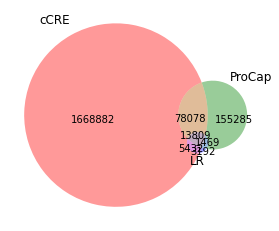

In [27]:
counts, int_beds = three_way_intersect(files_a,
                        files_a_name,
                        files_b,
                        files_b_name,
                        files_c,
                        files_c_name)

In [28]:
print(counts)
print(files_a_name)
print(files_b_name)
print(files_c_name)

{'001': 3192, '010': 155285, '011': 1469, '100': 1668882, '101': 5432, '110': 78078, '111': 13809}
cCRE
ProCap
LR


In [24]:
# int_beds

cCRE
1766201
1668882


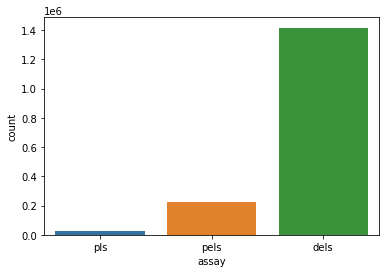

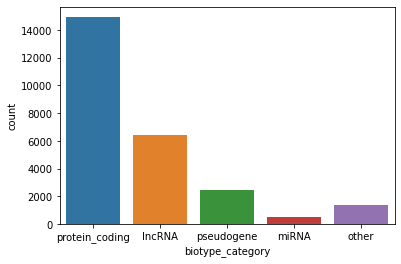

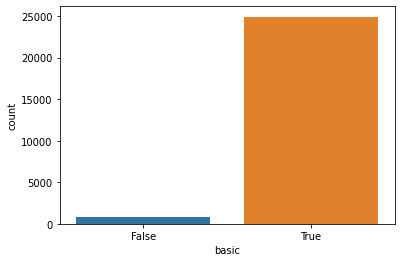


cCRE,LR
1766201
5432


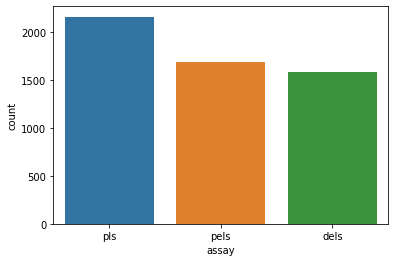

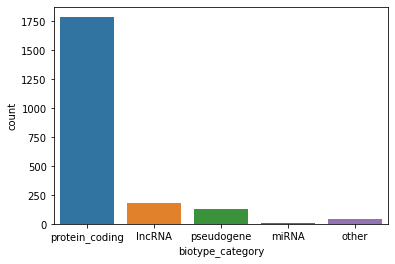

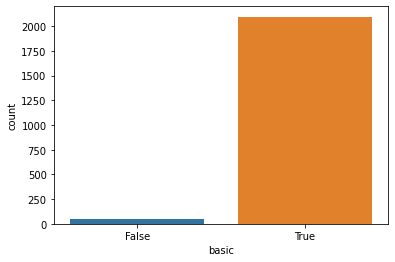


cCRE,ProCap
1766201
78078


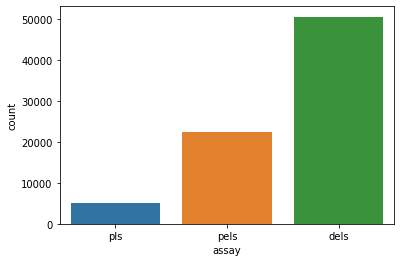

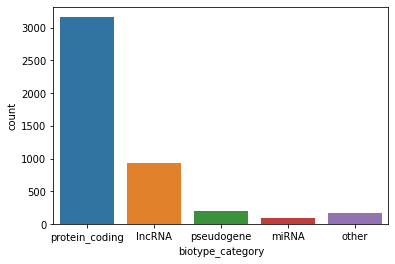

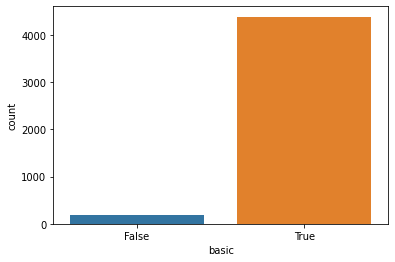


cCRE,ProCap,LR
1766201
13809


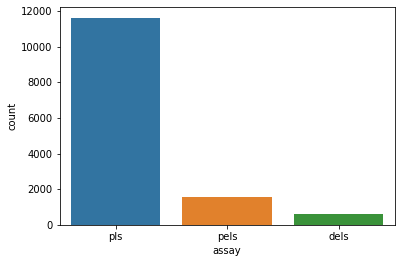

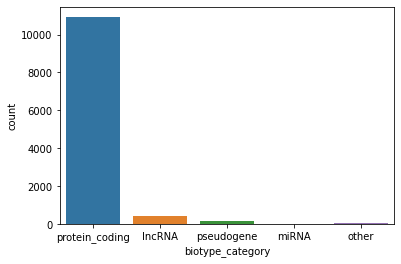

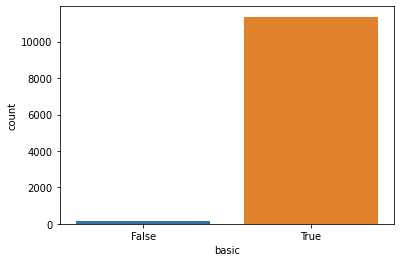

<Figure size 432x288 with 0 Axes>

In [25]:
for key, item in int_beds.items():
    if files_a_name not in key:
        continue
    print(key)
    df = int_beds[key]
    ccre_df = read_beds(files_a, files_a_name)    
    
      # this is wrong, the things from df are not supported
#     # get regions from original thing that were present in this
#     # intersection file
#     ccre_df['supported'] = False
#     ccre_df.loc[ccre_df.region_id.isin(df.region_id.tolist()), 'supported'] = True
#     temp = ccre_df[['assay', 'supported', 'region_id']].copy(deep=True)
#     temp = temp[['assay', 'region_id']].groupby('assay').count().reset_index().rename({'region_id':'n_total_ccres'}, axis=1)
#     temp2 = ccre_df[['assay', 'supported', 'region_id']].copy(deep=True)
#     temp2 = temp2.groupby(['assay', 'supported']).count().reset_index().rename({'region_id':'n_ccres'}, axis=1)
#     temp2 = temp2.merge(temp, on='assay', how='left')
#     temp2['perc'] = (temp2.n_ccres/temp2.n_total_ccres)*100
#     temp2 = temp2.loc[temp2.supported==True]
#     sns.catplot(temp2, x='assay', y='perc', kind='bar')    
#     import pdb; pdb.set_trace()
#     plt.show()
#     plt.clf()
    
    # get regions from original thing that were present in this
    # intersection file
    print(len(ccre_df.index))
    ccre_df = ccre_df.loc[ccre_df.region_id.isin(df.region_id.tolist())]
    print(len(ccre_df.index))
    sns.countplot(ccre_df, x='assay')    
    plt.show()
    plt.clf()
    
    # for plss, which types of genes are they from?
    pls_df = ccre_df.loc[ccre_df.assay=='pls']
    pls_df = pr.PyRanges(pls_df)
    pls_df = pls_df.join(gtf_df, 
                       how='left',
                       slack=200,
                       strandedness=None)
    pls_df = pls_df.df
    
    # biotype
    rank1, rank2 = get_biotype_ranks()
    pls_df['biotype_rank'] = pls_df.biotype_category.map(rank1)
    temp = pls_df.loc[pls_df.biotype_rank.notnull()]
    temp = temp.sort_values(by='biotype_rank', ascending=True)
    # pls_df.loc[pls_df.region_id=='cCRE_chr4_82402223_82402572']
    temp = temp.drop_duplicates(subset='region_id', keep='first')
    # pls_df.loc[pls_df.region_id=='cCRE_chr4_82402223_82402572']
    sns.countplot(temp, x='biotype_category')
    
    plt.show()
    plt.clf()
    
    # basic or not
    temp = pls_df.loc[pls_df.basic.notnull()]
    temp = temp.loc[temp.basic!='-1']
    temp = temp.sort_values(by='basic', ascending=False)
    temp = temp.drop_duplicates(subset='region_id', keep='first')
    sns.countplot(temp, x='basic')
    
    plt.show()
    plt.clf()
    print()


In [13]:
temp.basic.unique()
temp[['region_id', 'basic']].groupby('basic').count()

,region_id
basic,
False,169
True,11368


## LR characterization

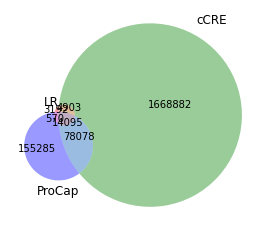

In [49]:
# what novelty types were the TSSs from LR associated with in each intersection?
counts, int_beds = three_way_intersect(files_c,
                        files_c_name,
                        files_a,
                        files_a_name,
                        files_b,
                        files_b_name)

In [51]:
print(counts)
print(files_c_name)
print(files_a_name)
print(files_b_name)

{'001': 155285, '010': 1668882, '011': 78078, '100': 3192, '101': 570, '110': 4903, '111': 14095}
LR
cCRE
ProCap


In [52]:
((50924-3192)/50924)*100

93.73183567669469

In [ ]:
ca = cerberus.read(ca_h5)

LR
50924
5220
153941
3214


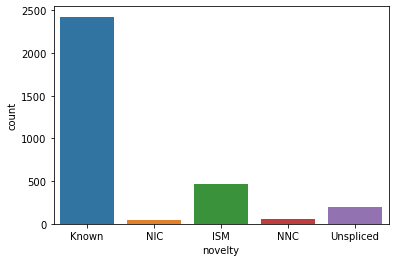


LR,ProCap
50924
1094
153941
575


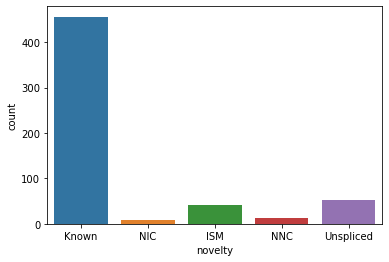


LR,cCRE
50924
8442
153941
4931


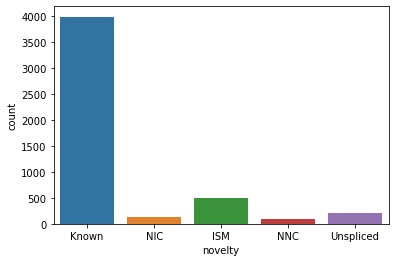


LR,cCRE,ProCap
50924
36168
153941
14151


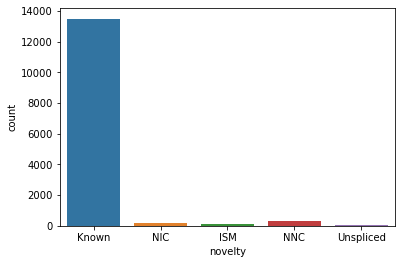

<Figure size 432x288 with 0 Axes>

In [338]:
for key, item in int_beds.items():
    if files_c_name not in key:
        continue
    print(key)
    df = int_beds[key]
    lr_df = read_beds(files_c, files_c_name)    
    
    # get regions from original thing that were present in this
    # intersection file
    print(len(lr_df.index))
    lr_df = lr_df.loc[lr_df.region_id.isin(df.region_id.tolist())]
    print(len(lr_df.index))
    tss_df = ca.tss.copy(deep=True)

    tss_df['group_name'] = files_c_name
    tss_df = make_unique_region_id(tss_df)
    print(len(tss_df.index))
    tss_df = tss_df.loc[tss_df.region_id.isin(df.region_id.tolist())]
    print(len(tss_df.index))

    tss_df = tss_df[['Name']]
    t_df = ca.t_map.loc[ca.t_map.source=='lapa']
    t_df = t_df.merge(ca.ic[['Name', 'novelty']].rename({'Name':'ic_id'}, axis=1),
                      how='left', on='ic_id')
    tss_df = tss_df.merge(t_df[['tss_id', 'novelty']].rename({'tss_id':'Name'}, axis=1),
                          on='Name', how='left')
    nov_rank, rank_nov = get_nov_ranks()
    tss_df['nov_rank'] = tss_df.novelty.map(nov_rank)
    tss_df = tss_df.loc[tss_df.nov_rank.notnull()]
    
    tss_df = tss_df.sort_values(by='nov_rank', ascending=True)
    tss_df = tss_df.drop_duplicates(subset='Name', keep='first')
    
    sns.countplot(data=tss_df, x='novelty')    
    plt.show()
    plt.clf()
    print()

## ProCap characterization

In [ ]:
gtf_df = pr.read_gtf(gtf_file)
gtf_df = gtf_df.df
gtf_df = gtf_df.loc[gtf_df.Feature=='gene']
gtf_df = gtf_df[['Chromosome', 'Start', 'End', 'Strand', 'gene_id']]
gtf_df = pr.PyRanges(gtf_df)

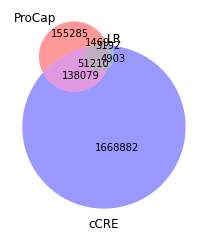

In [53]:
# what about genic vs. non-genic procap peaks?
# what novelty types were the TSSs from LR associated with in each intersection?
counts, int_beds = three_way_intersect(files_b,
                        files_b_name,
                        files_c,
                        files_c_name,
                        files_a,
                        files_a_name)

In [54]:
print(counts)
print(files_b_name)
print(files_c_name)
print(files_a_name)

{'001': 1668882, '010': 3192, '011': 4903, '100': 155285, '101': 138079, '110': 1469, '111': 51210}
ProCap
LR
cCRE


In [55]:
((351687-155285)/351687)*100

55.84568096062692

ProCap
351687
158582


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


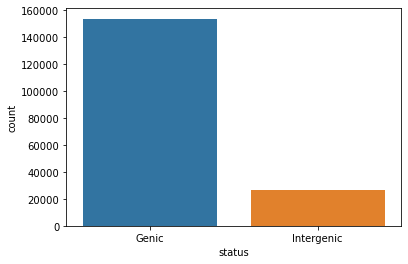

ProCap,cCRE
351687
140114


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


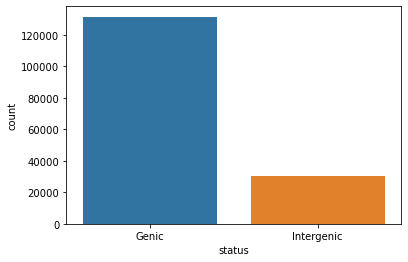

ProCap,LR
351687
1493


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


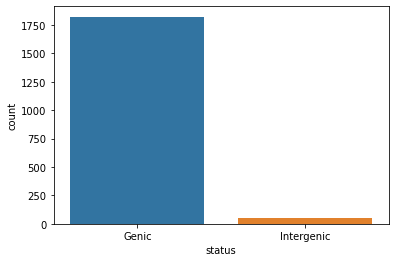

ProCap,LR,cCRE
351687
51498


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


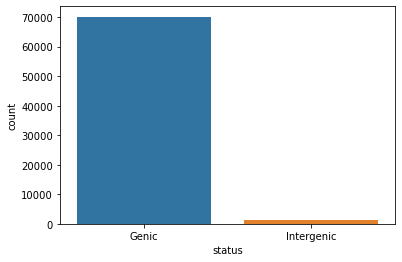

<Figure size 432x288 with 0 Axes>

In [386]:
for key, item in int_beds.items():
    if files_b_name not in key:
        continue
    print(key)
    df = int_beds[key]
    pc_df = read_beds(files_b, files_b_name)    
    
    # get regions from original thing that were present in this
    # intersection file
    print(len(pc_df.index))
    pc_df = pc_df.loc[pc_df.region_id.isin(df.region_id.tolist())]
    print(len(pc_df.index))
    
    pc_df = pr.PyRanges(pc_df)
    pc_df = pc_df.join(gtf_df, 
                       how='left', 
                       strandedness=None)
    pc_df = pc_df.df    
    pc_df['status'] = 'Genic'
    pc_df.loc[pc_df.gene_id == '-1', 'status'] = 'Intergenic'
    sns.countplot(data=pc_df, x='status')    

    plt.show()
    plt.clf()

## older

In [334]:
# tss_df.loc[tss_df.Name=='ENSG00000049656_3']

In [333]:
# tss_df.loc[tss_df.Name=='ENSG00000049656_3']

In [326]:
# ca.t_map.loc[ca.t_map.tss_id=='ENSG00000049656_3']

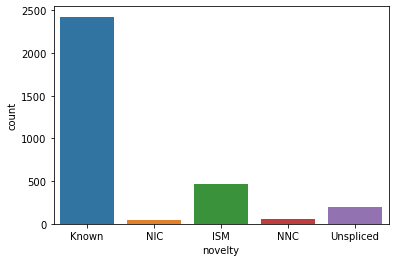

In [336]:
sns.countplot(data=tss_df, x='novelty')

In [253]:
# look at ccre types in each thing
key = 'cCRE,ProCap'
df = int_beds[key]
df.head()

,Chromosome,Start,End,group_name,region_id
0,chr1,904578,904918,cCRE,cCRE_chr1_904578_904918
1,chr1,923719,924069,cCRE,cCRE_chr1_923719_924069
2,chr1,925512,925850,cCRE,cCRE_chr1_925512_925850
3,chr1,1019822,1020170,cCRE,cCRE_chr1_1019822_1020170
4,chr1,1400363,1400692,cCRE,cCRE_chr1_1400363_1400692


In [254]:
ccre_df = read_beds(files_a, files_a_name)

In [255]:
ccre_df.head()

,Chromosome,Start,End,assay,group_name,region_id
0,chr1,778570,778919,pls,cCRE,cCRE_chr1_778570_778919
1,chr1,779023,779182,pls,cCRE,cCRE_chr1_779023_779182
2,chr1,817080,817403,pls,cCRE,cCRE_chr1_817080_817403
3,chr1,826734,826887,pls,cCRE,cCRE_chr1_826734_826887
4,chr1,826894,827162,pls,cCRE,cCRE_chr1_826894_827162


In [256]:
# get regions from original thing that were present in this
# intersection file
print(len(ccre_df.index))
ccre_df = ccre_df.loc[ccre_df.region_id.isin(df.region_id.tolist())]
print(len(ccre_df.index))

1766201
78078


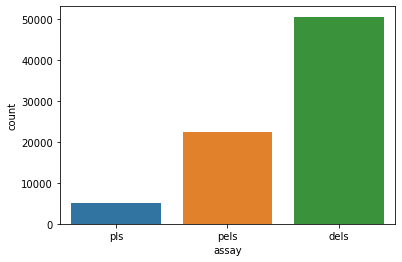

In [257]:
sns.countplot(ccre_df, x='assay')

In [178]:
# code largely stolen from here: https://github.com/asntech/intervene/blob/master/intervene/modules/upset/upset.py
weights = {}
intersect_beds = {}
input_files = ['test_bed_1.bed', 'test_bed_2.bed','test_bed_3.bed']
N=len(input_files)
truth_table = [x for x in itertools.product("01", repeat=N)][1:]
for t in truth_table:
    ones = [pr.read_bed(input_files[i]) for i in range(N) if t[i] =='1']
    zeros = [pr.read_bed(input_files[i]) for i in range(N) if t[i] =='0']
    # report those entries in set A which do ovelap with other sets
    x = ones[0]
    if len(ones) > 1:
        for bed in ones[1:]:
            print('here')
            x = x.overlap(bed,
                 how='first')
    # report those entries in set A which doesn't ovelap with other sets
    if len(zeros) > 0:
        for bed in zeros[0:]:
            x = x.overlap(bed,
                 how='first',
                 invert=True)
            
    # X = (x).count()
    X = len(x.df.index)
    
    temp = x.df
    n1 = len(temp.index)
    n2 = len(temp.ThickEnd.unique())
    if n1 != n2: import pdb; pdb.set_trace()
    
    
    weights[''.join(t)] = X
    intersect_beds[''.join(t)] = x.df

here
here
here
here
here


In [180]:
intersect_beds.keys()

dict_keys(['001', '010', '011', '100', '101', '110', '111'])

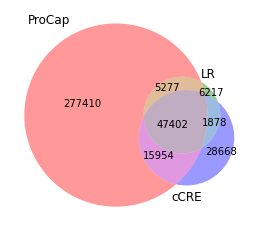

In [174]:
# all k562
venn3(weights, set_labels=['ProCap', 'LR', 'cCRE'])

In [168]:
for i in input_files:
    df = pr.read_bed(i).df
    print(len(df.index))

346043
22760
1766201


In [148]:
df = pr.read_bed('data/human/lr/k562_1.bed').df
def make_unique_region_id(df):
        """
        Make a unique region ID for BED regions that don't 
        alread have unique identifiers
        """
        df['region_id'] = df['Chromosome'].astype(str)+'_'+\
                          df['Start'].astype(str)+'_'+\
                          df['End'].astype(str)#+'_'+\
                          #df['Strand'].astype(str)
        return df
df = make_unique_region_id(df)
df.loc[df.region_id.duplicated(keep=False)].sort_values(by='region_id')

,Chromosome,Start,End,Name,Score,Strand,ThickStart,ThickEnd,ItemRGB,BlockCount,region_id
11562,chr16,69187096,69187214,ENSG00000168807_1,.,+,"v40,v29,lapa,encode_cage,fantom_cage,pls",Known,ENSG00000168807,1,chr16_69187096_69187214
11687,chr16,69187096,69187214,ENSG00000260914_2,.,+,"lapa,encode_cage,fantom_cage,pls",Novel,ENSG00000260914,2,chr16_69187096_69187214
13199,chr18,36187446,36187547,ENSG00000134759_16,.,+,"lapa,encode_cage,fantom_cage,pls",Novel,ENSG00000134759,16,chr18_36187446_36187547
13153,chr18,36187446,36187547,ENSG00000075643_1,.,+,"v40,v29,lapa,gtex,encode_cage,fantom_cage,pls",Known,ENSG00000075643,1,chr18_36187446_36187547
14212,chr19,46787764,46787865,ENSG00000105281_4,.,-,"lapa,pls,pels",Novel,ENSG00000105281,4,chr19_46787764_46787865
14043,chr19,46787764,46787865,ENSG00000275719_1,.,+,"v40,v29,lapa,pls,pels",Known,ENSG00000275719,1,chr19_46787764_46787865
1294,chr1,159925440,159925557,ENSG00000158710_1,.,-,"v40,v29,lapa,gtex,encode_cage,fantom_cage,enco...",Known,ENSG00000158710,1,chr1_159925440_159925557
1537,chr1,159925440,159925557,ENSG00000213085_7,.,-,"lapa,gtex,encode_cage,fantom_cage,encode_rampa...",Novel,ENSG00000213085,7,chr1_159925440_159925557
15454,chr22,16601426,16601527,ENSG00000283633_3,.,+,"lapa,encode_cage,fantom_cage,encode_rampage,pels",Novel,ENSG00000283633,3,chr22_16601426_16601527
15281,chr22,16601426,16601527,ENSG00000100181_6,.,+,"lapa,encode_cage,fantom_cage,encode_rampage,pels",Novel,ENSG00000100181,6,chr22_16601426_16601527


In [142]:
df = pd.read_csv('data/human/lr/k562_1_formatted.bed', sep='\t')
print(len(df.index))
print(len(df.drop_duplicates().index))
df.head()

16228
16215


,Chromosome,Start,End,assay,biosample,rep,output
0,chr1,169794989,169795129,lr,k562,1,NaN
1,chr1,169794679,169794780,lr,k562,1,NaN
2,chr1,196651703,196652106,lr,k562,1,NaN
3,chr1,24415751,24415908,lr,k562,1,NaN
4,chr1,23019392,23019518,lr,k562,1,NaN


In [138]:
df = pr.read_bed('test_bed_2.bed').df
df.loc[df.ThickEnd.duplicated(keep=False)].sort_values(by='ThickEnd')

,Chromosome,Start,End,Name,Score,Strand,ThickStart,ThickEnd
11562,chr16,69187096,69187214,.,.,.,lr,lr_chr16_69187096_69187214
11687,chr16,69187096,69187214,.,.,.,lr,lr_chr16_69187096_69187214
13199,chr18,36187446,36187547,.,.,.,lr,lr_chr18_36187446_36187547
13153,chr18,36187446,36187547,.,.,.,lr,lr_chr18_36187446_36187547
14212,chr19,46787764,46787865,.,.,.,lr,lr_chr19_46787764_46787865
14043,chr19,46787764,46787865,.,.,.,lr,lr_chr19_46787764_46787865
1294,chr1,159925440,159925557,.,.,.,lr,lr_chr1_159925440_159925557
1537,chr1,159925440,159925557,.,.,.,lr,lr_chr1_159925440_159925557
15454,chr22,16601426,16601527,.,.,.,lr,lr_chr22_16601426_16601527
15281,chr22,16601426,16601527,.,.,.,lr,lr_chr22_16601426_16601527


In [122]:
input_files

['test_bed_1.bed', 'test_bed_2.bed', 'test_bed_3.bed']

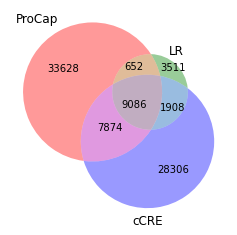

In [124]:
# a673 procap
venn3(weights, set_labels=['ProCap', 'LR', 'cCRE'])

In [125]:
3511+1908+652+9086 #lr

15157

In [126]:
7874+9086+19098+28306 # ccre

64364

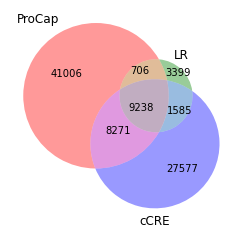

In [114]:
# mcf10a procap
venn3(weights, set_labels=['ProCap', 'LR', 'cCRE'])

In [127]:
706+3399+9238+1585#lr

14928

In [131]:
8271+9238+1585+27577# ccre

46671

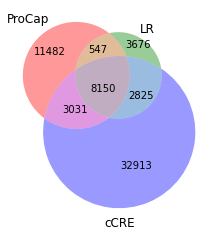

In [102]:
# k562 procap
venn3(weights, set_labels=['ProCap', 'LR', 'cCRE'])

In [132]:
547+3676+2825+8150# lr

15198

In [133]:
3031+8150+2825+32913 #ccre

46919

In [89]:
from matplotlib_venn import venn3


In [75]:
# def three_way_intersect(f1,
#                         f1_group,
#                         f2,
#                         f2_group,
#                         f3,
#                         f3_group):
#     def make_unique_region_id(df):
#         """
#         Make a unique region ID for BED regions that don't 
#         alread have unique identifiers
#         """
#         df['region_id'] = df['group_name']+'_'+\
#                           df['Chromosome']+'_'+\
#                           df['Start'].astype(str)+'_'+\
#                           df['End'].astype(str)#+'_'+\
#                           #df['Strand'].astype(str)
#         return df
    
#     def read_beds(files, name):
#         df = pd.DataFrame()
#         for f in files:
#             temp = pd.read_csv(f, sep='\t')
#             df = pd.concat([df, temp], axis=0)
            
#             # retain just the identifying characteristics 
#             # df = df[['Chromosome', 'Start', 'End', 'Strand']]
#             df = df[['Chromosome', 'Start', 'End']]
#         df['group_name']  = name
#         df = make_unique_region_id(df)
#         return df
    
#     def intersect_thing(a, a_name,
#                         b, b_name,
#                         c, c_name):
#         a_ids = a.region_id.unique().tolist()
#         b_ids = b.region_id.unique().tolist()
#         c_ids = c.region_id.unique().tolist()
        
#         # make a-b, a-c, and b-c comparisons
#         ab_ids = a.join(b,
#                         how=None, # none = inner
#                         slack=0,
#                         suffix='_other').df.region_id.unique().tolist()
#         ac_ids = a.join(c,
#                         how=None, # none = inner
#                         slack=0,
#                         suffix='other').df.region_id.unique()
#         bc_ids = b.join(c,
#                 how=None, # none = inner
#                 slack=0,
#                 suffix='other').df.region_id.unique()
        
#         # a ids
#         abc_ids = list(set(ab_ids)&set(ac_ids))
#         ab_ids = list(set(ab_ids)-set(abc_ids))
#         ac_ids = list(set(ac_ids)-set(abc_ids))
#         a_ids = list(set(a_ids)-\
#                      set(abc_ids)-\
#                      set(ab_ids)-\
#                      set(ac_ids))
        
#         # b ids
#         bc_ids = list(set(bc_ids)-set(abc_ids))
#         b_ids = list(set(b_ids)-\
#                      set(abc_ids)
        
        
#         # make a table
#         ids = a_ids+ab_ids+ac_ids+abc_ids
#         support = [a_name for i in range(len(a_ids))]
#         support += [f'{a_name},{b_name}' for i in range(len(ab_ids))]
#         support += [f'{a_name},{c_name}' for i in range(len(ac_ids))]
#         support += [f'{a_name},{b_name},{c_name}' for i in range(len(abc_ids))]
#         df = pd.DataFrame()
#         df['region_id'] = ids
#         df['support'] = support
#         return df
    
#     # read in beds
#     f1_df = read_beds(f1, 
#                       f1_group)
#     print(len(f1_df.index))
#     f2_df = read_beds(f2, 
#                       f2_group)
#     f3_df = read_beds(f3,
#                       f3_group)
    
#     # perform intersections: 
#     f1_pr = pr.PyRanges(f1_df)
#     f2_pr = pr.PyRanges(f2_df)
#     f3_pr = pr.PyRanges(f3_df)
    
#     # using regions from 1 as a reference
#     df = intersect_thing(f1_pr,
#                          f1_group,
#                          f2_pr,
#                          f2_group,
#                          f3_pr, 
#                          f3_group)

    
#     return df

In [63]:
print(len(df.index))

23210
